![Banner](img/AI_Special_Program_Banner.jpg)

## Convolutional Neural Networks (CNN) - Exercise - Sample Solution
---
Instructions are given in <span style="color:blue">blue</span> color.

For this exercise, you are asked to implement a convolutional neural network based on a proposed architecture to classify objects in the [worlds largest doodling dataset](https://quickdraw.withgoogle.com/data).

```Quick, Draw!``` is a project by Google in which people are asked to draw images of certain objects in a limited amount of time. You can actually contribute to the project yourself by visiting [this page](https://quickdraw.withgoogle.com/) and start doodling away. Can you muster the artistic skills it takes to get your images recognized?

The entire dataset contains more than 50 million drawings across more than 300 different categories. Luckily, the whole dataset [has been made open-source](https://github.com/googlecreativelab/quickdraw-dataset), allowing us to use the data for our own neural network training.

Since trying to classify the entire dataset in a single exercise would be a little overwhelming, we will be focusing on a subset of the drawings instead. However, we still want to tackle a little challenge. This is why we will be working with doodles that are not always as easily distinguishable - not even for the human eye.

In [1]:
# The categories we want to classify
classes = ['Apple', 'Baseball', 'Basketball', 'Blueberry', 'Circle', 'Clock', 'Cookie', 'Donut', 'Face', 'Pizza']

In [2]:
# Packages and libraries
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm.notebook import trange, tqdm
import torch
# force gpu computing, when gpu library is available
USE_GPU = True
device = torch.device("cuda" if torch.cuda.is_available() and USE_GPU else "cpu")
print(f'Using {device}')

Using cuda


<span style="color:blue">As in the material notebook, please use the helper functions for the training loop</span>

In [3]:
# helper functions for the training loop
from train_loop import train, train_for_epochs, validate

In [4]:
%matplotlib inline

In [5]:
# Random seeds
np.random.seed(42)
torch.manual_seed(42)

In [6]:
# Data source path
source_path = "data/QD_Data/"

# Images and labels
training_img_file = "QD_Training_Data.npy"
validation_img_file = "QD_Validation_Data.npy"
testing_img_file = "QD_Testing_Data.npy"
training_label_file = "QD_Training_Labels.npy"
validation_label_file = "QD_Validation_Labels.npy"
testing_label_file = "QD_Testing_Labels.npy"

## 1. Importing the data

* First, we get the data ready to work with on your local machine. You can download the data from this course's Moodle page. In total, six files have been prepared for you: the training data, the validation data, and the testing data along with their respective labels. All files are stored in the binary <code>.npy</code> format. The content of these files is loaded into your workspace with the help of NumPy's <code>load()</code> function.

In [7]:
training_img = np.load(f'{source_path}{training_img_file}')
validation_img = np.load(f'{source_path}{validation_img_file}')
testing_img = np.load(f'{source_path}{testing_img_file}')

training_label = np.load(f'{source_path}{training_label_file}')
validation_label = np.load(f'{source_path}{validation_label_file}')
testing_label = np.load(f'{source_path}{testing_label_file}')

## 2. Exploring the data

* Numer of samples for training, validation and testing.

In [8]:
print(f'There are {len(training_img)} samples for training, {len(validation_img)} for validation, and {len(testing_img)} for testing')

There are 350000 samples for training, 100000 for validation, and 50000 for testing


* Are the classes balanced? Let us see out how many samples there are for each category in the three datasets.

Distribution of training data


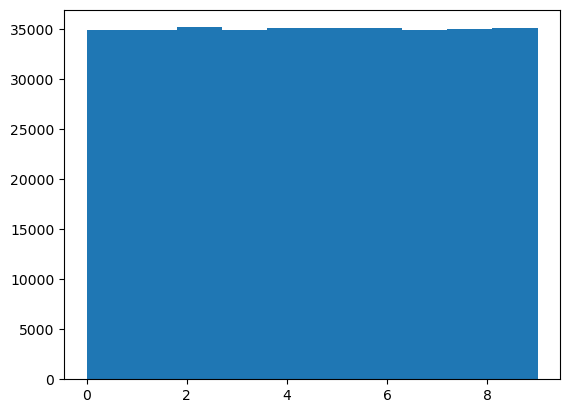

array([34905., 34931., 35161., 34891., 35055., 35058., 35081., 34910.,
       34960., 35048.])

In [9]:
print('Distribution of training data')
n, bins, patches = plt.hist(training_label)
plt.show()
n

Distribution of validation data


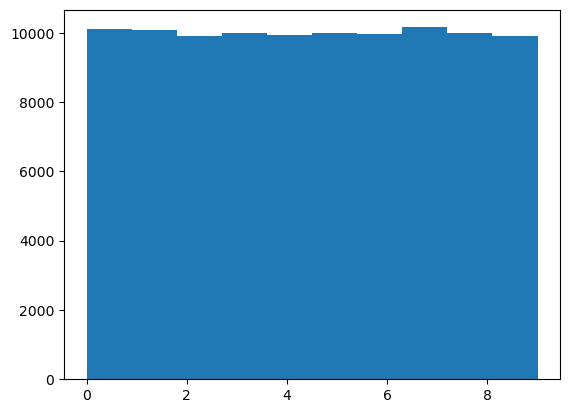

array([10098., 10078.,  9893., 10002.,  9926.,  9979.,  9977., 10158.,
        9991.,  9898.])

In [10]:
print('Distribution of validation data')
n, bins, patches = plt.hist(validation_label)
plt.show()
n

Distribution of test data


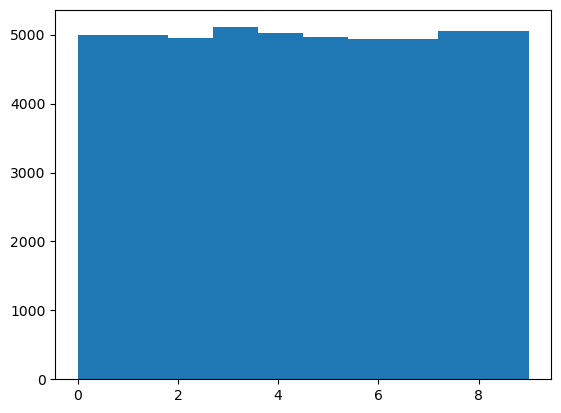

array([4997., 4991., 4946., 5107., 5019., 4963., 4942., 4932., 5049.,
       5054.])

In [11]:
print('Distribution of test data')
n, bins, patches = plt.hist(testing_label)
plt.show()
n

Optimally, those results should help you to conclude that there is plenty of data to train with, and the classes are all very well balanced. However, this is usually (and unfortunately) seldom the case. Try to think of a situation where there are not enough images to train a network.

One possible method to tackle this issue is found in **Data Augmentation**.

* <div style="color:blue">Please describe, in your own words, what Data Augmentation is and how it can be used to increase model performance.</div>

*Your solution (statement) goes here:*
The idea is to create more data by *modifying* existing images (or other data for other AI tasks). For images, there are various ways of doing this, e.g. cropping, flipping, or adjusting contrast, brightness, and saturation. But even if there is enough data available, data augmentation may be a good idea because it should help the model to generalize better, i.e. to *reduce overfitting*.

* Let us visualize the first image of the training set in conjunction with its correct label (category).

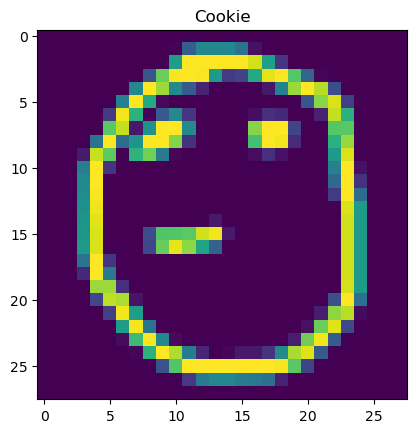

In [12]:
plt.imshow(training_img[0])
plt.title(classes[int(training_label[0])])
plt.show()

* Now let us have a look at the first 25 images of the testing set in conjunction with their correct labels (categories). Are you able to accurately identify each doodle?

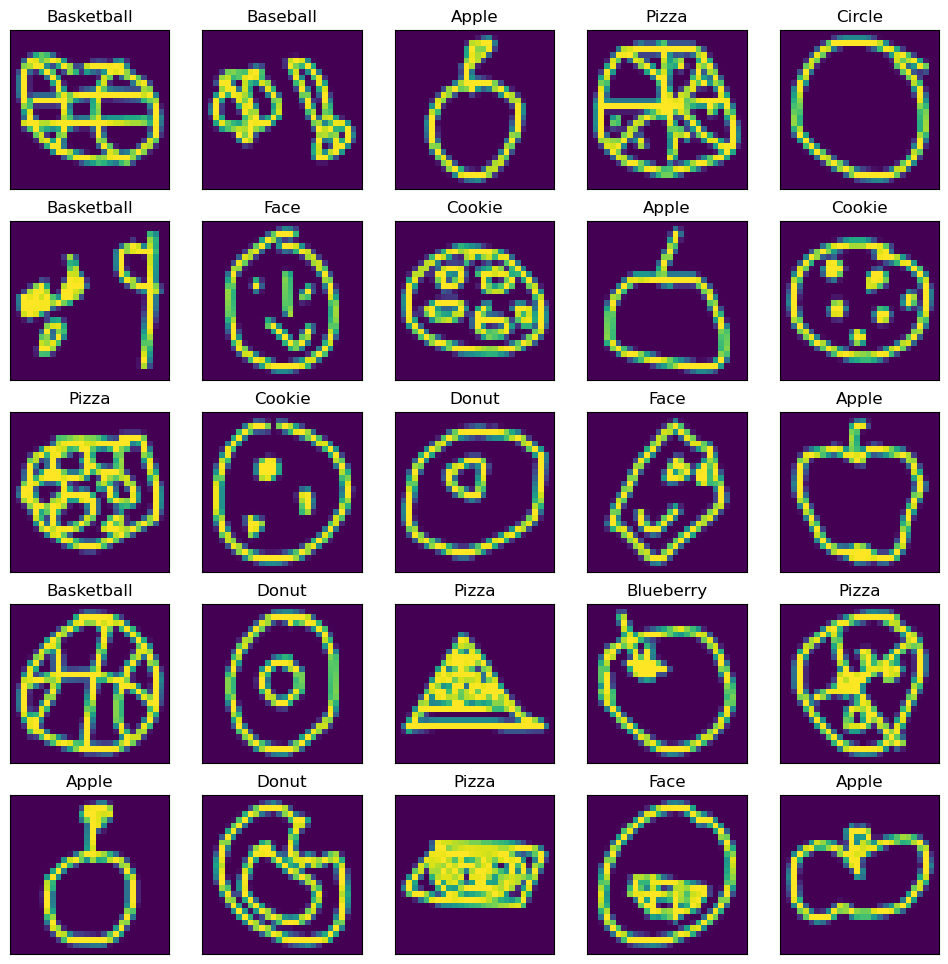

In [13]:
fig = plt.figure(figsize=(12, 12))
for i in range(25):
    label = classes[int(testing_label[i])]
    ax = fig.add_subplot(5, 5, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = testing_img[i]
    ax.imshow(img)
    ax.set_title(label)

## 3. Preprocess the data and build a dataset

In terms of preprocessing the data, there is not much left for you to do. The provided image data has a similar format as the MNIST data you have seen several times by now.

* Images are represented by $28x28$ grayscale pixels.
* Each pixel holds a value between $0$ and $255$.

Before designing and training your network, you have to build a dataset and make sure those pixel values are scaled between 0 and 1.

* <div style="color:blue">Build a PyTorch dataset and instantiate it for the training, validation, and test data</div>

* <div style="color:blue">Scale your data's pixel values to the range <b>[0, 1]</b>.</div>

**Hint**: Make sure to perform all preprocessing tasks on your training as well as your validation and test data.

In [14]:
# Your solution goes here:

# build a dataset
class DoodleDataset(Dataset):
    
    def __init__(self, data, labels):
        self.labels = torch.from_numpy(labels)
        #scale between 0 and 1
        self.data = data / 255
        #transform to tensor
        self.data = torch.from_numpy(data)
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx].long()
        img = self.data[idx].float().view(1, 28, 28)
        return img, label
    
train_dataset = DoodleDataset(training_img, training_label)
val_dataset = DoodleDataset(validation_img, validation_label)
test_dataset = DoodleDataset(testing_img, testing_label)

## 4. Build the model

Now that all the data is available and adequately preprocessed, it is time to create your convolutional neural network. Typically, the process of designing the model can take quite a while as there is no single best CNN architecture, taking into account the vast amount of hyperparameters and model options. Thus, finding a network structure that perfectly suits your data (and use-case) is a considerable effort on its own.

* <div style="color:blue">For this exercise, however, you will not design your own network. Instead, you are asked to implement the following CNN (using <code>PyTorch</code>):</div>

<img src="img/Ex_CNN_Model_Visualization.png" width="1000"/>

* <div style="color:blue">Each convolutional layer applies a 3x3 filter with a 1x1 stride. The images will be padded so that the convolved feature maps retain the <b>same</b> size. The number of filters (kernels) should be taken from the visualization above.</div>
* <div style="color:blue">Subsampling is achieved by using Max-Pooling with a pool size of 2x2 (for each pooling layer).</div>
* <div style="color:blue">Apart from the final dense layer, activation happens with the help of the Rectified Linear Unit (ReLU). The last layer should output a probability distribution of the categories.</div>
* <div style="color:blue">After the first dense layer, dropout regularization is performed with a dropout rate of 0.5.</div>

**Hint**: Printing an instance of your model object will print an overview of your current model architecture. The CNN you are asked to implement should produce the following output:

<img src="img/Ex_CNN_Model_Summary_PYTORCH.png" width="700"/>

In [15]:
# Your solution goes here:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 7 * 7, 256)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Create an instance of the CNN model
model = CNN()
model

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1568, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

## 5. Setup dataloader and optimizer

* <div style="color:blue">After defining the model architecture, you can now create a dataloader for the train and test dataset, setup an optimizer, and define a loss function. Use the Following:</div>

    * **Optimizer**: Adam
    * **Loss-Function**: torch.nn.CrossEntropyLoss
    * **Metrics**: Accuracy
   
Try to find a suitable value for the batch size (the number of images fed into the network at once). <br>
Also move the model to the correct device by calling <code>model.to(device)</code> on it

In [16]:
# Your solution goes here:

BATCH_SIZE = 256

# setup data laoder
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters())

# move model to device
model.to(device)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1568, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

The following sets up the train validation loop for training the network. <span style="color:blue">As in the material notebook, please use the helper functions for the training loop (see the imports above)</span>

## 6. Train the model

* <div style="color:blue">Now, train (fit) your model on the training data. Find suitable values for the number of epochs. (It is actually possible to break the 90% accuracy barrier.)</div>

In [17]:
# Your solution goes here:
NUM_EPOCHS = 15
history = train_for_epochs(device, NUM_EPOCHS, model, train_loader, val_loader, optimizer, criterion, binary=False)

  0%|          | 0/15 [00:00<?, ?it/s]

* Let us visualize how the accuracy and the loss values for both testing and training data have evolved during model training.

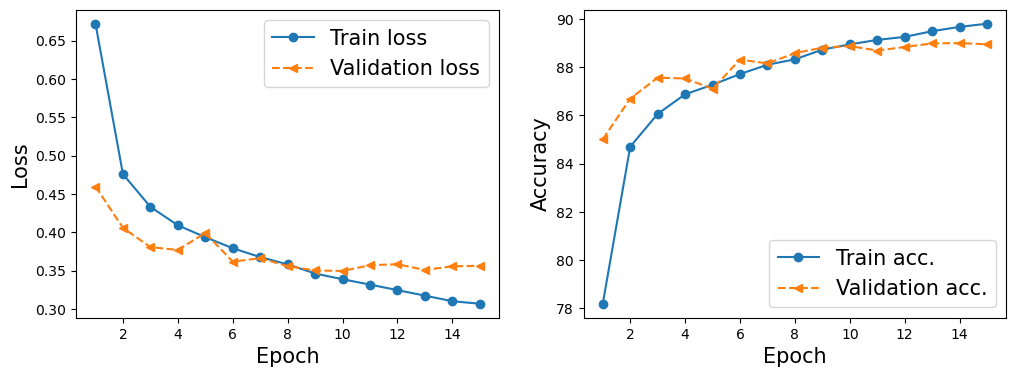

In [18]:
loss_train_hist = history['train']['loss']
acc_train_hist = history['train']['accuracy']
loss_val_hist = history['val']['loss']
acc_val_hist = history['val']['accuracy']

x_arr = np.arange(len(loss_train_hist)) + 1

with plt.ioff():
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, loss_train_hist, '-o', label='Train loss')
    ax.plot(x_arr, loss_val_hist, '--<', label='Validation loss')
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)
    ax.legend(fontsize=15)
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, acc_train_hist, '-o', label='Train acc.')
    ax.plot(x_arr, acc_val_hist, '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)

plt.show()

In [19]:
test_loss, test_accuracy = validate(device, model, test_loader, criterion, binary=False)
print('\nTest Acc. {:.2f}%'.format(test_accuracy))


Test Acc. 88.88%


## 7. Using the trained model

* Let us finally put the model to use and make some predictions.

In [20]:
# function for predicting the class at a given index by a trained model
def predict(model, data, binary=True):
    model.eval()
    data = data.unsqueeze(0).to(device)
    with torch.no_grad():
        #predict
        outputs = model(data).squeeze().cpu()
        # Get the prediction by selecting the class with the highest probability
        outputs = torch.softmax(outputs, 0)
        _, predicted = torch.max(outputs, 0)
        return predicted, outputs

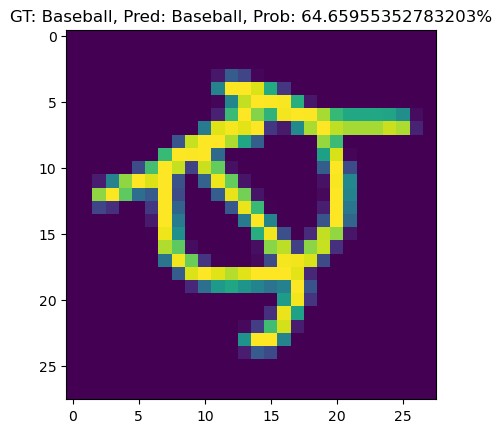

In [21]:
# Example for test image at index 883
idx = 883
sample, label = test_dataset[idx]
img = testing_img[idx]
pred, probs = predict(model, sample, binary=False)

plt.imshow(img)
plt.title(f'GT: {classes[label]}, Pred: {classes[pred]}, Prob: {probs[pred] * 100}%')

plt.show()

* <div style="color:blue">Visualize the entire probability distribution for the prediction of that same image sample. What is your network's second-best guess?</div>

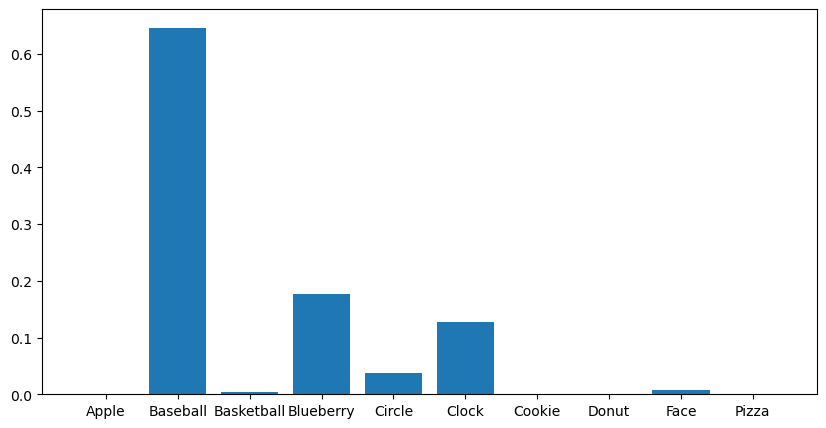

In [22]:
# Your solution goes here:

# Create a histogram
fig = plt.figure(figsize=(10, 5))
plt.bar(classes, probs)
plt.show()

*Your solution (statement) goes here:* The network gets it wrong: it thinks, this is a *Blueberry*, even though a *Baseball* is depicted. However, the network's second best guess would be *Baseball*.

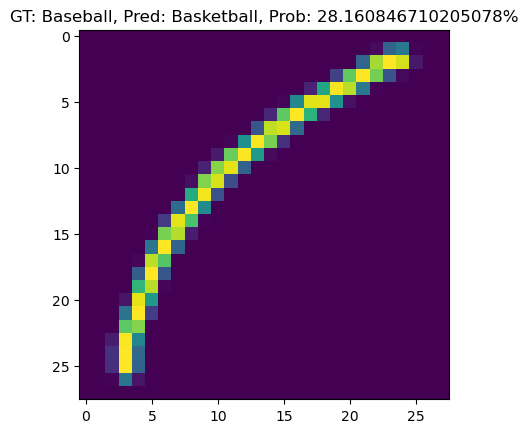

In [23]:
# Example for test image at index 22866
idx = 22866
sample, label = test_dataset[idx]
img = testing_img[idx]
pred, probs = predict(model, sample, binary=False)

plt.imshow(img)
plt.title(f'GT: {classes[label]}, Pred: {classes[pred]}, Prob: {probs[pred] * 100}%')

plt.show()

* <div style="color:blue">Visualize the entire probability distribution for the prediction of that same image sample. What are your thoughts?</div>

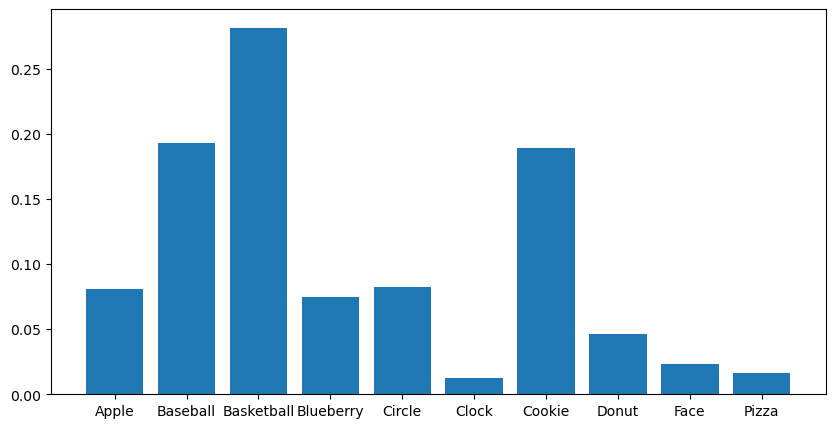

In [24]:
# Your solution goes here:

# Create a histogram
fig = plt.figure(figsize=(10, 5))
plt.bar(classes, probs)
plt.show()

*Your solution (statement) goes here:* Obviously, this is anyone's guess since the shape does not really resemble any of the objects to be doodled. The barchart depicts the model's confusion quite well.